In [1]:
import tensorflow as tf # 텐서플로
from tensorflow import keras # 케라스

import numpy as np
import pandas as pd
import FinanceDataReader as fdr
        
import matplotlib as mpl
%matplotlib inline
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from PIL import Image
from IPython.display import Image as Imgdisplay

import glob
import argparse
import os

import shutil
import psutil
from pathlib import Path

from trend_labeling import seq_seq_trend
from candlechart4ML import candlechart_generator

In [2]:
tf.__version__ # 텐서플로 버전확인

'2.8.0'

In [3]:
keras.__version__ # 케라스 버전확인

'2.8.0'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() # 로컬에 있는 디바이스(프로세서) 확인

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7415585181681063891
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7807696896
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17204632751548550562
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [5]:
def removeOutput(filepath):
    if(Path(filepath)).is_file():
        os.remove(filepath)
    
def csv_initiator(market, ticker, head_date, tail_date):
    df = fdr.DataReader(ticker, head_date, tail_date, exchange=market)
    
    filedir = os.getcwd() + '\\dataset\\raw_data\\'
    filename = "{}_{}.csv".format(market, ticker)    
    filepath = filedir + filename
    
    if not os.path.exists(filedir):
        os.makedirs(filedir)    
    removeOutput(filepath)
    df.to_csv(filepath)
    
    print("csv file saved as : {}".format(filepath))
    
    return filepath

In [6]:
# main
market = 'KRX'
ticker = '005930'
seq_len = 20
tre_len = 20
head_date = '2000-01-01'
tail_date = '2022-01-01'
dimension = 60
use_volume = False

data_csv_path = csv_initiator(market, ticker, head_date, tail_date)
label_set_path = seq_seq_trend(data_csv_path, seq_len=seq_len, tre_len=tre_len)
candlechart_dir = candlechart_generator(data_csv_path, seq_len=seq_len, tre_len=tre_len, dimension=dimension, use_volume=use_volume)

csv file saved as : C:\Users\SeungHyuck\Documents\github_remote\AI-Trade\DL Quant Strategy\multiperceptron-keras\dataset\raw_data\KRX_005930.csv
Creating label . . .
type : Sequence to Sequence
sequence_length : 20, trend_sequence_length : 20, gap : 0
Create label finished.
Converting ohlc to candlestick
Converting finished


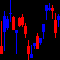

In [7]:
Imgdisplay(candlechart_dir + os.listdir(candlechart_dir)[0], height=180, width=180) # 생성된 캔들차트 샘플확인

In [8]:
# 캔들차트이미지를 데이터 셋으로
# 한 픽셀의 RGB 값, 한 변의 픽셀 수는 dimension
def image2gray(candlechart_dir):
    symbol = candlechart_dir.split('\\')[-3]
    imgs = list([])
    for i in range(len(os.listdir(candlechart_dir))):
        imgname = '{}-{}.png'.format(symbol, i)
        im = Image.open(candlechart_dir+imgname)
        imGray = im.convert('L')
        imGray.save(candlechart_dir+imgname)

def image2_2Ddataarray(candlechart_dir):
    symbol = candlechart_dir.split('\\')[-3]
    imgs = list([])
    for i in range(len(os.listdir(candlechart_dir))):
        imgname = '{}-{}.png'.format(symbol, i)
        im = Image.open(candlechart_dir+imgname)
        imGray = im.convert('L')
        imgs.append(np.array(imGray))

    return np.array(imgs)

        
def label2dataarray(label_set_path):
    label_array = list([])
    with open(label_set_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            label = int(line.split(',')[-1])
            if label==0:
                label_array.append([1, 0])
            else:
                label_array.append([0, 1])
        return np.array(label_array)

In [9]:
# image2gray(candlechart_dir)
candle_array = image2_2Ddataarray(candlechart_dir)
label_array = label2dataarray(label_set_path)
# print(len(candle_array), len(label_array))

In [10]:
X_all = candle_array / 255.0
y_all = label_array

slicer1 = int(0.8 * len(candle_array))

X_train_full, y_train_full = X_all[:slicer1], y_all[:slicer1]
X_test, y_test = X_all[slicer1:], y_all[slicer1:]

slicer2 = int(0.8 * len(X_train_full))

X_valid, X_train = X_train_full[slicer2:], X_train_full[:slicer2]
y_valid, y_train = y_train_full[slicer2:], y_train_full[:slicer2]

In [11]:
y_train

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [12]:
X_all.shape

(5389, 60, 60)

In [13]:
X_all.dtype

dtype('float64')

In [14]:
X_train

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.11372549, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.11372549, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.11372549, 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [15]:
# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=[60, 60])) # 단위 데이터의 shape 지정
# model.add(keras.layers.Dense(300, activation="relu"))
# model.add(keras.layers.Dense(100, activation="relu"))
# model.add(keras.layers.Dense(2, activation="softmax"))

In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[60, 60]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2, activation="sigmoid")
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 300)               1080300   
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,110,602
Trainable params: 1,110,602
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.layers

In [19]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [20]:
model.get_layer('dense') is hidden1

True

In [21]:
weights, biases = hidden1.get_weights()

In [22]:
weights

array([[-0.02978723,  0.00995041, -0.0175252 , ...,  0.01363073,
         0.01630506,  0.02597472],
       [ 0.00674931,  0.03245709,  0.02171681, ...,  0.0334013 ,
         0.03071899, -0.00330049],
       [-0.02835115,  0.02897163,  0.02766484, ...,  0.01400426,
        -0.02153269,  0.00345062],
       ...,
       [ 0.0184726 , -0.02971625,  0.02074389, ...,  0.03165545,
        -0.01998522, -0.01658939],
       [ 0.00403665,  0.00786809,  0.01630467, ..., -0.02240757,
        -0.03303299,  0.00177924],
       [-0.02814909, -0.0162084 ,  0.00953759, ..., -0.03112601,
        -0.01314731, -0.01013807]], dtype=float32)

In [23]:
weights.shape

(3600, 300)

In [24]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [25]:
biases.shape

(300,)

In [26]:
model.compile(loss="binary_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

In [27]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
108/108 [==============================] - 2s 4ms/step - loss: 0.6863 - accuracy: 0.5754 - val_loss: 0.6711 - val_accuracy: 0.7126
Epoch 2/30
108/108 [==============================] - 0s 2ms/step - loss: 0.6729 - accuracy: 0.6233 - val_loss: 0.6512 - val_accuracy: 0.7103
Epoch 3/30
108/108 [==============================] - 0s 2ms/step - loss: 0.6598 - accuracy: 0.6607 - val_loss: 0.6318 - val_accuracy: 0.7300
Epoch 4/30
108/108 [==============================] - 0s 2ms/step - loss: 0.6455 - accuracy: 0.6859 - val_loss: 0.6149 - val_accuracy: 0.7648
Epoch 5/30
108/108 [==============================] - 0s 2ms/step - loss: 0.6300 - accuracy: 0.7108 - val_loss: 0.5975 - val_accuracy: 0.7659
Epoch 6/30
108/108 [==============================] - 0s 2ms/step - loss: 0.6144 - accuracy: 0.7155 - val_loss: 0.5795 - val_accuracy: 0.7636
Epoch 7/30
108/108 [==============================] - 0s 2ms/step - loss: 0.6004 - accuracy: 0.7164 - val_loss: 0.5667 - val_accuracy: 0.7659
Epoch 